In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
import seaborn as sns
import matplotlib.gridspec as gridspec
import scipy
from scipy.stats import norm
import pylab

In [2]:
df = pd.read_csv('/Users/jedapa/Desktop/MIOTI_proyecto.csv')
pd.to_datetime(df['time'])
df['time'] = pd.to_datetime(df['time'])
df['time'] = df['time'].dt.strftime('%Y/%m/%d %H:%m')
#Para hacer resampling tiene que ser DatetimeIndex
df['time'] = pd.DatetimeIndex(df['time'])

In [3]:
# DATOS ORIGNALES
df

,name,time,device,host,kpi,product_model,value,version
0,Composite.nh,2020-04-11 17:04:00,hl4acap9-301,open-nti,Composite.nh,NaN,3013,20190306.8b08cc0_builder_stable_10
1,Composite.nh,2020-04-11 17:04:00,hl4lsca7-301,open-nti,Composite.nh,NaN,837,20190306.8b08cc0_builder_stable_10
2,Composite.nh,2020-04-11 17:04:00,hl4lsca7-302,open-nti,Composite.nh,NaN,769,20190306.8b08cc0_builder_stable_10
3,Composite.nh,2020-04-11 17:04:00,hl4fnfn7-301,open-nti,Composite.nh,NaN,966,20190306.8b08cc0_builder_stable_10
4,Composite.nh,2020-04-11 17:04:00,hl4luba1-302,open-nti,Composite.nh,NaN,2061,20190306.8b08cc0_builder_stable_10
...,...,...,...,...,...,...,...,...
14812996,route-table.summary.inet.3.rsvp,2020-04-29 14:04:00,hl4lnto1-302,open-nti,route-table.summary.inet.3.rsvp,NaN,11,20190306.8b08cc0_builder_stable_10
14812997,route-table.summary.inet.3.rsvp,2020-04-29 14:04:00,hl4bcp1-301,open-nti,route-table.summary.inet.3.rsvp,NaN,4,20190306.8b08cc0_builder_stable_10
14812998,route-table.summary.inet.3.rsvp,2020-04-29 14:04:00,hl4bgr1-301,open-nti,route-table.summary.inet.3.rsvp,NaN,4,20190306.8b08cc0_builder_stable_10
14812999,route-table.summary.inet.3.rsvp,2020-04-29 14:04:00,hl4bete1-301,open-nti,route-table.summary.inet.3.rsvp,NaN,4,20190306.8b08cc0_builder_stable_10


In [4]:
df.shape

(14813001, 8)

In [5]:
# PIVOT table in order to get KPIs as a columns.

df_pivot = df.pivot_table(values='value',index=['device','time'],columns='kpi')
df_pivot_final = df_pivot.reset_index(level = 1, col_level = 1)
df_pivot_final

# REMOVING $protocols.lsi.count

df_pivot_final.drop(['$protocols.lsi.count'], axis=1,inplace=True)

# Dealing with NAN by means of interpolation.

df_pivot_final_test = df_pivot_final.copy()
interpolate = df_pivot_final_test.interpolate().bfill()
interpolate.isnull().sum()
df_pivot_final_test = interpolate
df_pivot_final_test.shape

(194935, 92)

In [137]:
df_pivot_final_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 194935 entries, hl413vdpn1-301 to hl4zuba1-301
Data columns (total 92 columns):
 #   Column                                              Non-Null Count   Dtype         
---  ------                                              --------------   -----         
 0   time                                                194935 non-null  datetime64[ns]
 1   Composite.nh                                        194935 non-null  float64       
 2   EDMEM.percent                                       194935 non-null  float64       
 3   IDMEM.percent                                       194935 non-null  float64       
 4   Indirect.nh                                         194935 non-null  float64       
 5   Label.nh                                            194935 non-null  float64       
 6   Unicast.nh                                          194935 non-null  float64       
 7   Unilist.nh                                          194935 non-null  

In [134]:
print(df_pivot_final_test.describe())

kpi     Composite.nh  EDMEM.percent  IDMEM.percent    Indirect.nh  \
count  194935.000000  194935.000000  194935.000000  194935.000000   
mean     2452.661556      46.060695      94.365896   16807.338202   
std      2480.536776       1.931491       2.151633    1431.277784   
min         0.000000      43.000000      82.000000       0.000000   
25%      1058.000000      44.000000      92.000000   16044.000000   
50%      1644.000000      46.000000      95.000000   16506.000000   
75%      3032.000000      47.000000      96.000000   17580.000000   
max     33550.000000      55.000000      97.000000   26374.000000   

kpi         Label.nh     Unicast.nh     Unilist.nh  \
count  194935.000000  194935.000000  194935.000000   
mean    21240.176405   18317.396414   12185.731385   
std     17585.399460    3166.320021    2066.187467   
min         0.000000       0.000000       0.000000   
25%      5402.000000   16786.000000   11106.000000   
50%     21417.000000   17627.000000   12240.000000   


In [144]:
#Agrupando por equipo(unas 249 muestras por KPI a est y sacando la media)
# El ejercicio es predecir el size de la nhdb en base a parametros.
df_test = df_pivot_final_test.groupby(df_pivot_final_test.index)[['ifd.count','ifl.count','route-table.summary.inet.0.BGP','route-table.summary.inet.0.access_internal','route-table.summary.inet.0.isis','route-table.summary.inet.0.static','route-table.summary.inet.3.BGP','route-table.summary.inet.3.ldp','route-table.summary.inet.3.rsvp','bng.subscribers.summary.session-state-total','protocols.igmp.gropus.count','protocols.instances.vpls.count','protocols.instances.vrf.count','protocols.isis.adjacency.count','protocols.l2circuit.count','protocols.ldp.neighbor.count','protocols.ldp.session.count','protocols.lsi.count','protocols.rsvp.session.count']].mean()

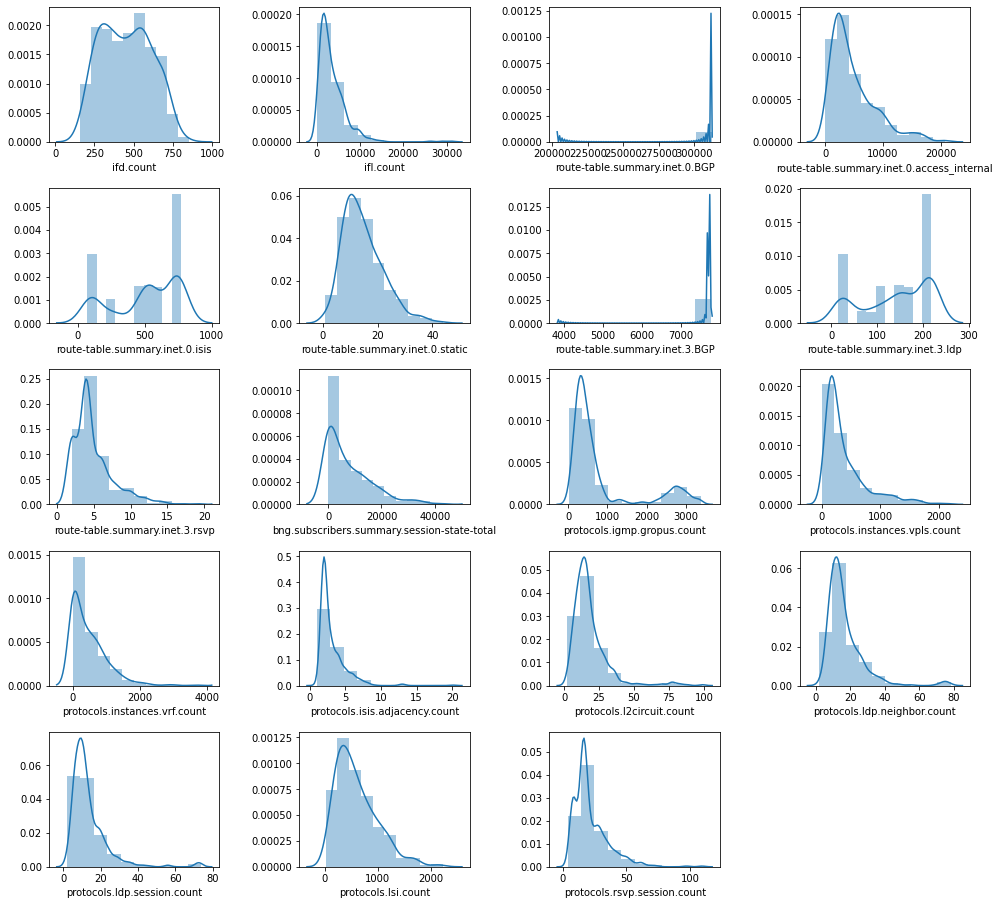

In [145]:
#fv = df_test['protocols.rsvp.session.count']
#plt.figure(figsize=(8,5))   
#b = sns.distplot(fv, bins=10)
#b.set_xlabel("rsvp_sess",fontsize=20)
#b.tick_params(labelsize=10)
#plt.show()
#
#print('El valor de asimetría de rsvp_sess es: '+str(scipy.stats.skew(fv)))
#print('El valor de curtosis de rsvp_sess es: '+str(scipy.stats.kurtosis(fv)))
#sns.pairplot(df_test.loc[:,df_test.dtypes == 'float64'])

## TODO: asimetria y curtosis en la grafica
fig, ax = plt.subplots(figsize = (14, 50))
for i, col in enumerate(df_test.columns):
    plt.subplot(20, 4, i+1)
    sns.distplot(df_test.iloc[:,i],bins=10)
    plt.axis('on')
plt.tight_layout()

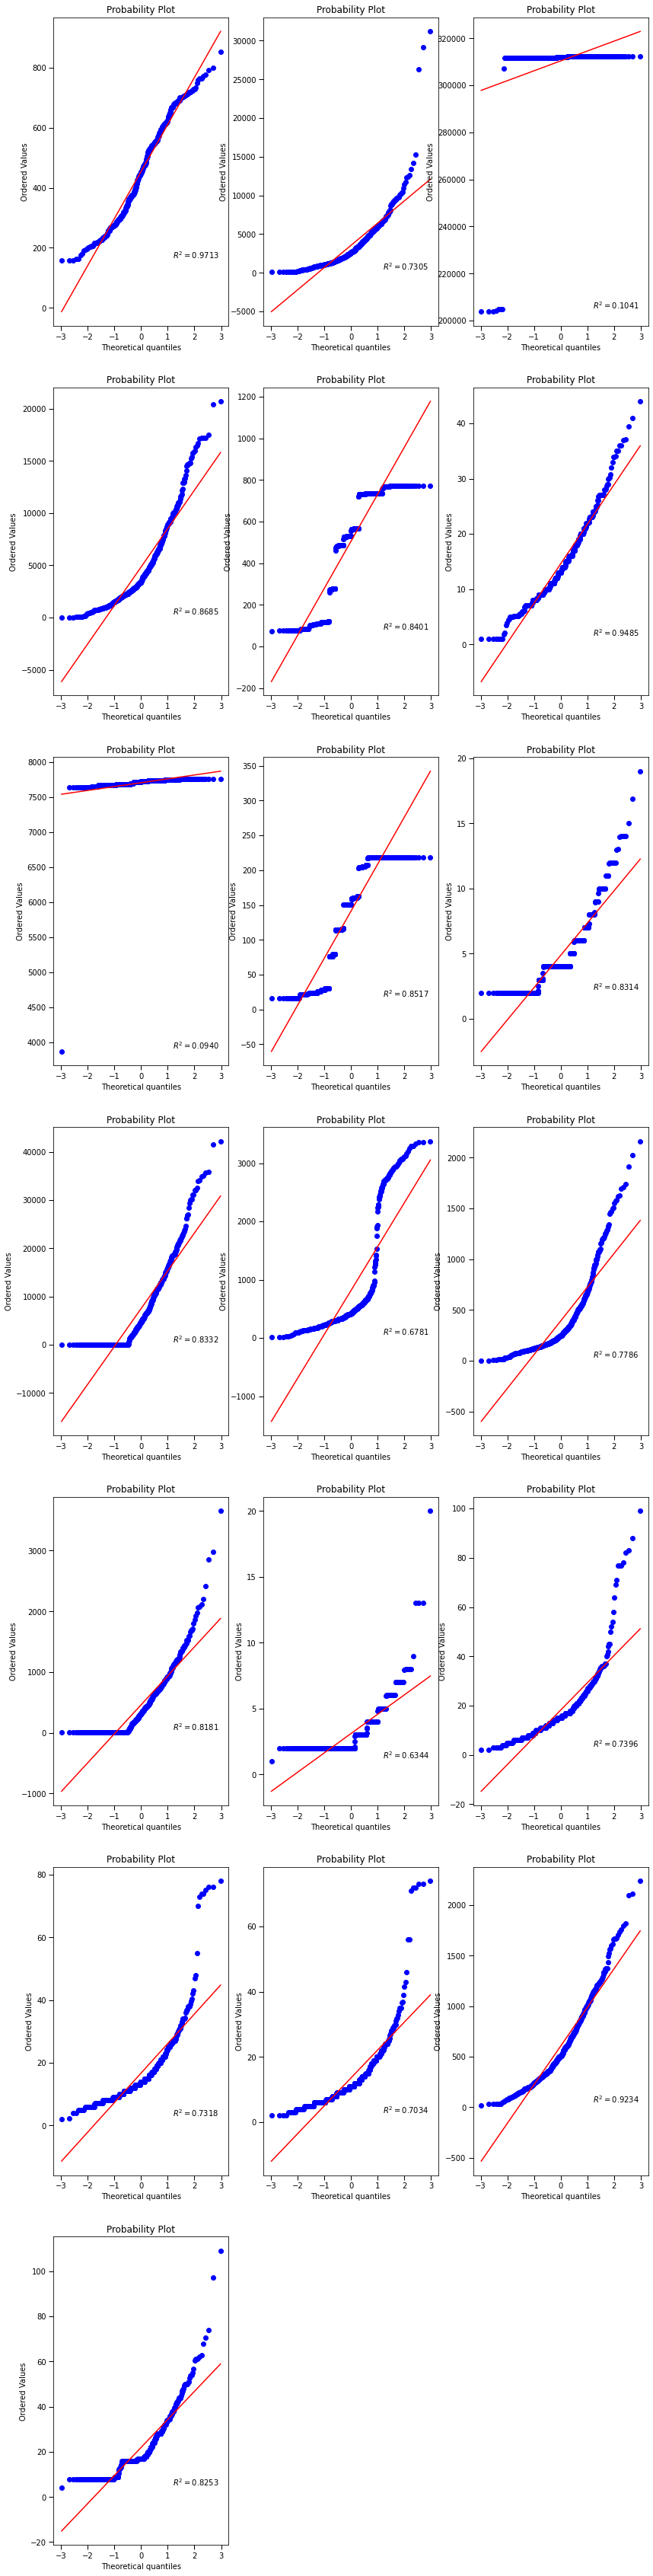

In [146]:
# QQ-plot
#Un gráfico Cuantil-Cuantil permite observar cuan cerca está la distribución de un conjunto de datos a alguna distribución ideal 
#ó comparar la distribución de dos conjuntos de datos
fig, ax = plt.subplots(figsize = (14, 70))
for i, col in enumerate(df_test.columns):
    plt.subplot(8, 3, i+1)
    plt.axis('on')
    plt.tick_params(length=6, width=1, grid_alpha=0.1)
    stats.probplot(df_test.iloc[:,i], dist="norm", plot=plt, rvalue=True)
pylab.show()

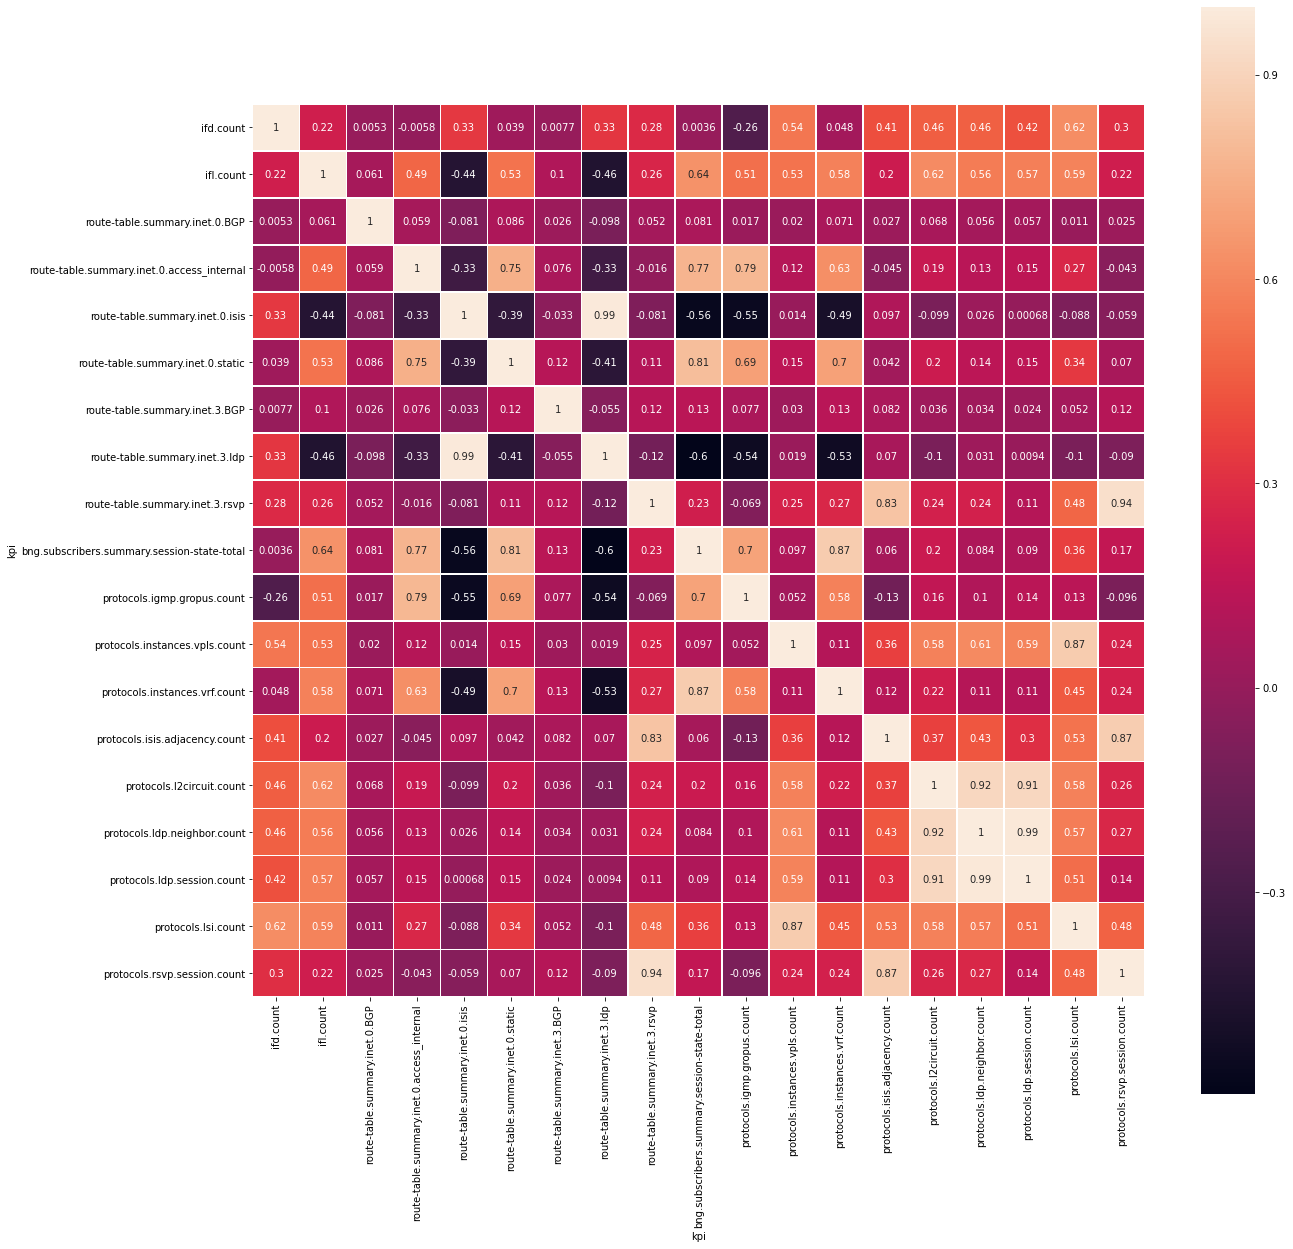

In [147]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0,20.0)
df_test.corr()
sns.heatmap(df_test.corr(),square=True,annot=True,linewidths=.5)

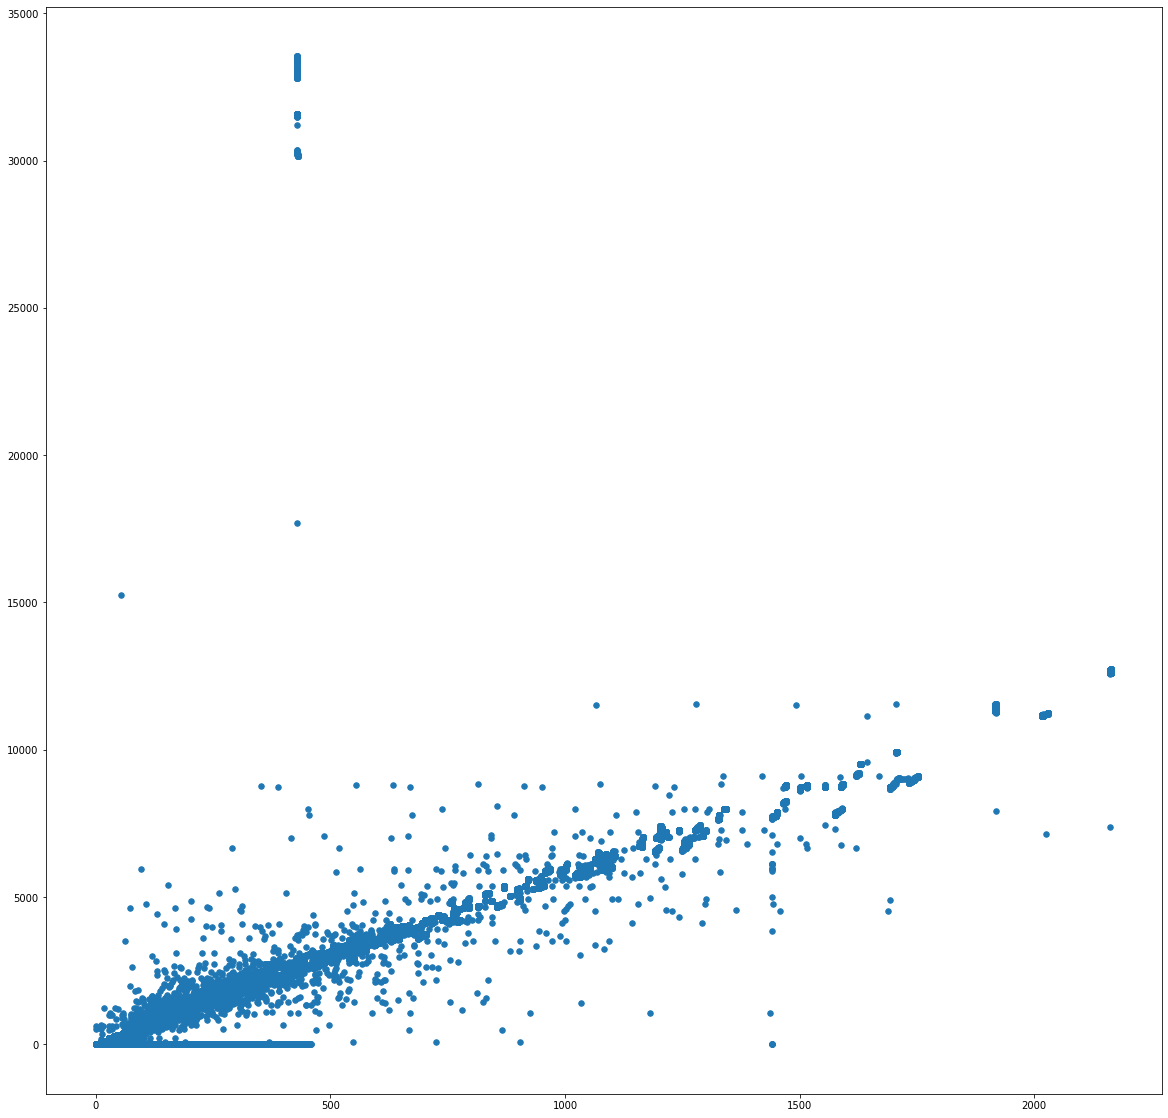

In [12]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

colores=['orange','blue']
tamanios=[30,60]

f1 = df_pivot_filtered['protocols.instances.vpls.count'].values
f2 = df_pivot_filtered['Composite.nh'].values

#features = df_pivot_filtered.iloc[:,0:6].columns

#plt.figure(figsize=(12,28*4))
#gs = gridspec.GridSpec(28,1)
#for i,cn in enumerate(df_pivot_filtered[features]):
#    ax = plt.subplot(gs[i])
#    sns.distplot(df[cn],bins=50)
#    ax.set_xlabel('')
#    ax.set_tittle('Histogram of feature: ', + str(cn))
#plot.show()
plt.scatter(f1, f2, s=tamanios[0])
plt.show()
#df_pivot_filtered['Composite.nh'].hist()
#df_pivot_filtered['ifl.count'].hist()

Coefficients: 
 [5.56903085]
Independent term: 
 261.9749310000848
Mean squared error: 1805454.50
Variance score: 0.71


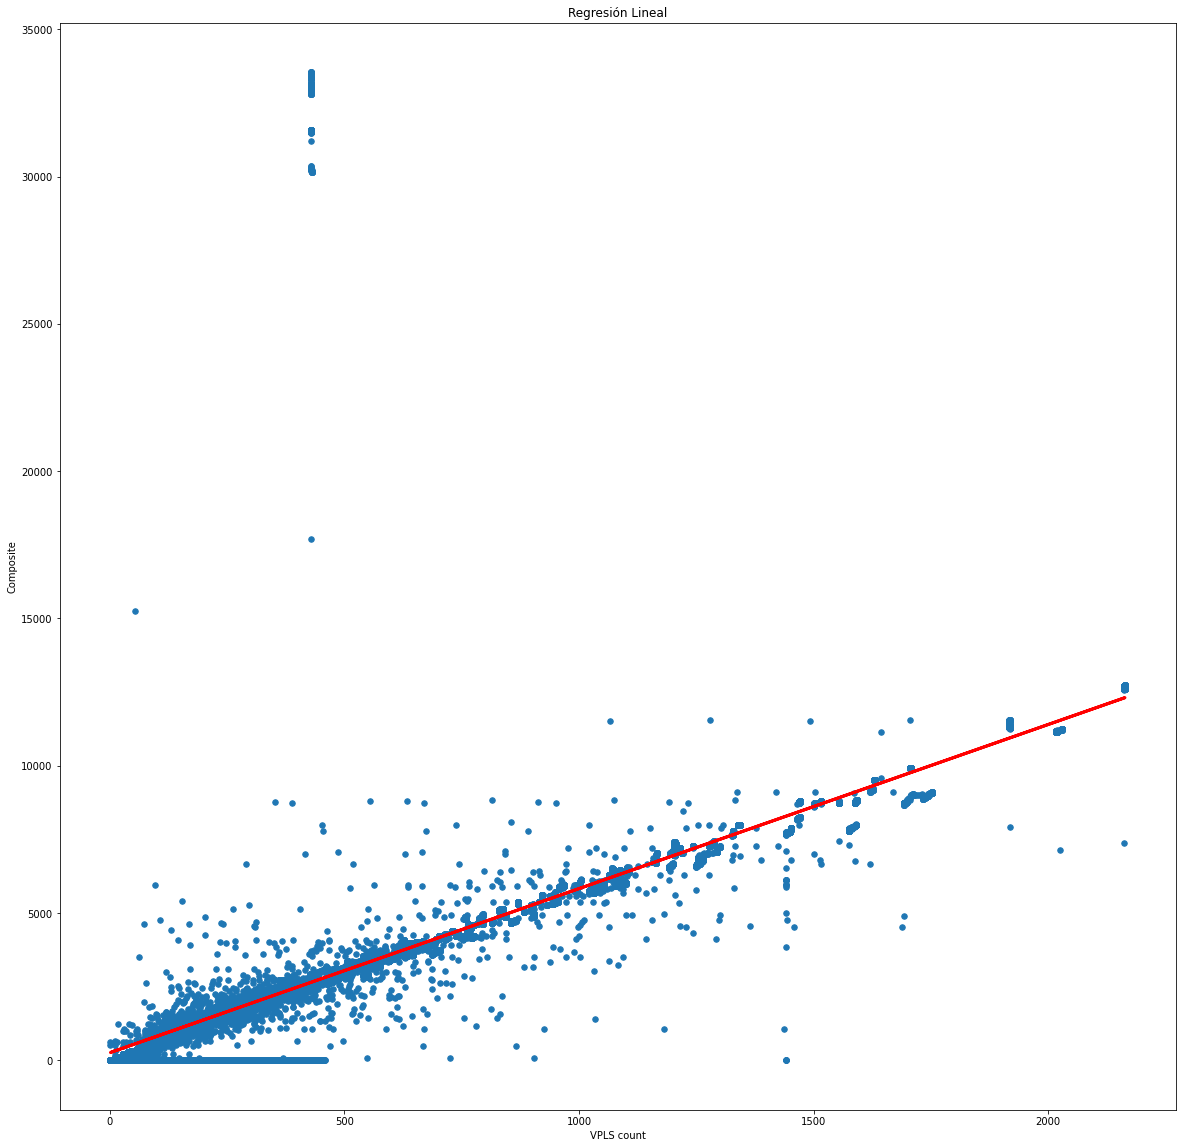

Recta de mejor ajuste: Y = 261.9749310000848 + [5.56903085]*x


In [13]:
# Asignamos nuestra variable de entrada X para entrenamiento y las etiquetas Y.
dataX =df_pivot_filtered[["protocols.instances.vpls.count"]]
X_train = np.array(dataX)
Y_train = df_pivot_filtered['Composite.nh'].values

# Creamos el objeto de Regresión Linear
regr = linear_model.LinearRegression()

# Entrenamos nuestro modelo
regr.fit(X_train, Y_train)

# Hacemos las predicciones que en definitiva son una línea (en este caso, al ser 2D)
y_pred = regr.predict(X_train)

# Veamos los coeficienetes obtenidos, En nuestro caso, serán la Tangente
print('Coefficients: \n', regr.coef_)
# Este es el valor donde corta el eje Y (en X=0)
print('Independent term: \n', regr.intercept_)
# Error Cuadrado Medio
print("Mean squared error: %.2f" % mean_squared_error(Y_train, y_pred))
# Puntaje de Varianza. El mejor puntaje es un 1.0
print('Variance score: %.2f' % r2_score(Y_train, y_pred))
plt.scatter(X_train[:,0], Y_train, s=tamanios[0])
plt.plot(X_train[:,0], y_pred, color='red', linewidth=3)

plt.xlabel('VPLS count')
plt.ylabel('Composite')
plt.title('Regresión Lineal')

plt.show()
print("Recta de mejor ajuste: Y = {0} + {1}*x".format(regr.intercept_,regr.coef_))